# max Intensity vs duration

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import dask
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import intake
from scipy.stats import linregress
import cartopy.crs as ccrs
from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
from dask.distributed import Client, LocalCluster
import subprocess
import re
import dask.array as da

import warnings
warnings.filterwarnings('ignore')

In [2]:

import dask
from dask.distributed import Client, LocalCluster
import bokeh

dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
#cluster = LocalCluster(
#    n_workers=10,              # 10 workers × 8GB = 80GB (20% buffer)
#    threads_per_worker=1,      # Avoid thread contention
#    memory_limit="8GB",
#    memory_spill_fraction=0.6, # Aggressive spilling
#    memory_pause_fraction=0.8
#)
cluster = LocalCluster(n_workers=32,threads_per_worker=2)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/b382616/levante-spawner-preset//proxy/42745/status,
Dashboard: /user/b382616/levante-spawner-preset//proxy/42745/status,Workers: 32
Total threads: 64,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37795,Workers: 32
Dashboard: /user/b382616/levante-spawner-preset//proxy/42745/status,Total threads: 64
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:44561,Total threads: 2
Dashboard: /user/b382616/levante-spawner-preset//proxy/44199/status,Memory: 7.36 GiB
Nanny: tcp://127.0.0.1:42487,


In [3]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() / 'mhws' 

In [4]:
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'extreme_events_binary_ord2.zarr'
#chunk_size = {'time': 25, 'lat': -1, 'lon': -1}
chunks={'time': 50, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds = xr.open_zarr(str(file_name), chunks=chunks)
ssta=ds['dat_detrend']

In [5]:
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'MHWs_tracked_2ndorder.zarr'
blobs_ds = xr.open_zarr(str(file_name), chunks={'time': 50})

In [8]:
# SUBSET
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'extremes_binary_gridded_subset.zarr'
#chunk_size = {'time': 25, 'lat': -1, 'lon': -1}
chunks={'time': 150, 'lat': -1, 'lon': -1}
ds = xr.open_zarr(str(file_name), chunks=chunks)
ssta=ds['dat_detrend']

file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'extreme_events_merged_SUBSET.zarr'
blobs_ds = xr.open_zarr(str(file_name), chunks={'time': 500, 'ID': 1000})

In [6]:

blobs = blobs_ds.ID_field#.chunk({'time':500})
presence = blobs_ds.presence
IDs = blobs_ds.ID.chunk({'ID':500})


<xarray.DataArray 'dat_detrend' (time: 13879, lat: 721, lon: 1440)> Size: 115GB
dask.array<open_dataset-dat_detrend, shape=(13879, 721, 1440), dtype=float64, chunksize=(50, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 111kB 2002-01-01T23:59:00 ... 2039-12-31T2...

In [52]:
#max_int=(ssta.where(blobs==IDs).max(dim={'lat','lon','time'}))

# MAX INTENSITY


In [12]:
%%time
#it processes slices of IDs at a time
results = []
def max_intensity(sst_np, id_field_np, id_val):
    mask = id_field_np == id_val. #mask of Trues and Falses
    if not np.any(mask):  #if there is at least a true (where ID meets SSTA)
        return np.nan
    # Explicit type conversion
    return float(np.nanmax(sst_np[mask].astype('float32')))
        
for id_start in range(0, len(IDs), 500):
    id_end = id_start + 500
    print(f"Processing IDs {id_start}-{id_end}")
    
    # Select current batch of IDs
    IDs_batch = IDs.isel(ID=slice(id_start, id_end))
    
    # Compute max intensity for this batch
    intensity_batch = xr.apply_ufunc(
        max_intensity,
        ssta,
        blobs,
        IDs_batch,
        input_core_dims=[["lat", "lon"], ["lat", "lon"], []],
        output_core_dims=[[]],
        dask="parallelized",
        vectorize=True,
        output_dtypes=[float],
        dask_gufunc_kwargs={"allow_rechunk": True}
    ).max(dim="time")
    
    # Compute and clear memory
    results.append(intensity_batch.compute())
    del intensity_batch

Processing IDs 0-500
Processing IDs 500-1000


2025-03-31 22:01:25,348 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.48 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:01:27,680 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.96 GiB -- Worker memory limit: 15.62 GiB


Processing IDs 1000-1500


2025-03-31 22:03:40,765 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.95 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:03:41,460 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.87 GiB -- Worker memory limit: 15.62 GiB


Processing IDs 1500-2000


2025-03-31 22:05:52,492 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.57 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:05:52,912 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.40 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:05:59,906 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

Processing IDs 2000-2500


2025-03-31 22:08:04,387 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.55 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:08:11,099 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.91 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:08:22,826 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

Processing IDs 2500-3000


2025-03-31 22:10:53,578 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.29 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:10:54,686 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 12.93 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:10:56,302 - distributed.worker.memory - WARNING - Worker is at 77% memory usage. Resuming worker. Process memory: 12.16 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:11:14,646 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanage

Processing IDs 3000-3500


2025-03-31 22:12:59,933 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.07 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:13:13,113 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.19 GiB -- Worker memory limit: 15.62 GiB


Processing IDs 3500-4000


2025-03-31 22:15:05,537 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.80 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:15:08,866 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 12.81 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:15:12,650 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process memory: 12.24 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:15:15,935 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:43045 (pid=261747) exceeded 95% memory budget. Restarting...
2025-03-31 22:15:17,691 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:43045' caused the cluster to lose already computed task(s), wh

Processing IDs 4000-4500


2025-03-31 22:17:30,920 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.07 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:17:44,320 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.91 GiB -- Worker memory limit: 15.62 GiB


Processing IDs 4500-5000


2025-03-31 22:19:34,823 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.76 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:19:35,714 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 12.50 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:19:35,833 - distributed.worker.memory - WARNING - Worker is at 76% memory usage. Resuming worker. Process memory: 11.92 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:19:37,738 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged

Processing IDs 5000-5500


2025-03-31 22:21:53,174 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 12.85 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:21:54,497 - distributed.worker.memory - WARNING - Worker is at 74% memory usage. Resuming worker. Process memory: 11.69 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:22:03,742 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.75 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:22:14,908 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged

Processing IDs 5500-6000


2025-03-31 22:24:06,565 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.47 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:24:06,609 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 12.51 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:24:07,004 - distributed.worker.memory - WARNING - Worker is at 73% memory usage. Resuming worker. Process memory: 11.46 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:24:08,655 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanage

Processing IDs 6000-6500


2025-03-31 22:26:47,113 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.45 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:26:52,430 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 13.15 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:26:53,337 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.04 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:26:54,045 - distributed.worker.memory - WARNING - Worker is at 76% memory usage. Resuming worker. Process

Processing IDs 6500-7000


2025-03-31 22:28:54,896 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.46 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:29:23,208 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.09 GiB -- Worker memory limit: 15.62 GiB


Processing IDs 7000-7500


2025-03-31 22:31:12,299 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.64 GiB -- Worker memory limit: 15.62 GiB


Processing IDs 7500-8000


2025-03-31 22:33:25,546 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 12.52 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:33:25,718 - distributed.worker.memory - WARNING - Worker is at 76% memory usage. Resuming worker. Process memory: 11.97 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:33:41,675 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.87 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:33:45,588 - distributed.worker.memory - WARNING - Worker is at 86% memory usage. Pausing worker.  Process memory: 13.50 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:33:46,612 - distributed.worker.memory - WARNING - Worker is at 75% memory usage. Resuming worker. Process memory: 1

Processing IDs 8000-8500


2025-03-31 22:35:32,404 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 12.60 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:35:33,151 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 12.38 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:35:34,746 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.39 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:35:34,840 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanage

Processing IDs 8500-9000


2025-03-31 22:37:42,349 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.80 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:37:58,674 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.44 GiB -- Worker memory limit: 15.62 GiB


Processing IDs 9000-9500


2025-03-31 22:39:53,579 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.86 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:39:54,283 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.46 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:40:02,617 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 13.19 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:40:03,857 - distributed.worker.memory - WARNING - Worker is at 78% memory usage. Resuming worker. Process

Processing IDs 9500-10000


2025-03-31 22:42:00,789 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.44 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:43:08,670 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.57 GiB -- Worker memory limit: 15.62 GiB


Processing IDs 10000-10500


2025-03-31 22:44:16,091 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.37 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:44:20,828 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.47 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:44:40,394 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

Processing IDs 10500-11000


2025-03-31 22:46:57,112 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.44 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:47:04,383 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 12.79 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:47:09,704 - distributed.worker.memory - WARNING - Worker is at 75% memory usage. Resuming worker. Process memory: 11.79 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:47:10,169 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged

Processing IDs 11000-11500


2025-03-31 22:49:05,133 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.18 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:49:06,071 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.47 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:49:14,215 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 12.99 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:49:14,954 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:36591 (pid=261856) exceeded 95% m

Processing IDs 11500-12000


2025-03-31 22:51:34,300 - distributed.worker.memory - WARNING - Worker is at 87% memory usage. Pausing worker.  Process memory: 13.70 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:51:35,112 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 10.39 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:51:35,381 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.85 GiB -- Worker memory limit: 15.62 GiB
2025-03-31 22:51:36,963 - distributed.worker.memory - WARNING - Worker is at 77% memory usage. Resuming worker. Process

CPU times: user 21min 18s, sys: 6min 20s, total: 27min 39s
Wall time: 53min 47s


In [13]:
max_intensity_total = xr.concat(results, dim="ID")
max_intensity_total.to_netcdf("mhw_max_intensities.nc")

In [26]:
max_intensity_total=xr.open_dataset("mhw_max_intensities.nc")
# convert it to a DataArray first
max_intensity_total = max_intensity_total.to_array().squeeze()

# mean INTENSITY


In [7]:
%%time
#it processes slices of IDs at a time
results = []
def mean_intensity(sst_np, id_field_np, id_val):
    mask = id_field_np == id_val #mask of Trues and Falses
    if not np.any(mask):  #if there is at least a true (where ID meets SSTA)
        return np.nan
    # Explicit type conversion
    return float(np.nanmean(sst_np[mask].astype('float32')))
        
for id_start in range(0, len(IDs), 500):
    id_end = id_start + 500
    print(f"Processing IDs {id_start}-{id_end}")
    
    # Select current batch of IDs
    IDs_batch = IDs.isel(ID=slice(id_start, id_end))
    
    # Compute max intensity for this batch
    intensity_batch = xr.apply_ufunc(
        mean_intensity,
        ssta,
        blobs,
        IDs_batch,
        input_core_dims=[["lat", "lon"], ["lat", "lon"], []],
        output_core_dims=[[]],
        dask="parallelized",
        vectorize=True,
        output_dtypes=[float],
        dask_gufunc_kwargs={"allow_rechunk": True}
    ).mean(dim="time")
    
    # Compute and clear memory
    results.append(intensity_batch.compute())
    del intensity_batch

Processing IDs 0-500
Processing IDs 500-1000
Processing IDs 1000-1500
Processing IDs 1500-2000
Processing IDs 2000-2500
Processing IDs 2500-3000
Processing IDs 3000-3500
Processing IDs 3500-4000
Processing IDs 4000-4500
Processing IDs 4500-5000
Processing IDs 5000-5500
Processing IDs 5500-6000
Processing IDs 6000-6500
Processing IDs 6500-7000
Processing IDs 7000-7500
Processing IDs 7500-8000
Processing IDs 8000-8500
Processing IDs 8500-9000
Processing IDs 9000-9500
Processing IDs 9500-10000


2025-04-02 14:52:08,531 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-ID_field-1a31379977a6742fe771b824fd656889' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7ffe6b7e53a0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffe84cd89c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x7ffe6b7e53a0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(

Processing IDs 10000-10500
Processing IDs 10500-11000
Processing IDs 11000-11500


2025-04-02 14:55:59,341 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.92 GiB -- Worker memory limit: 7.36 GiB


Processing IDs 11500-12000
CPU times: user 9min 28s, sys: 2min 8s, total: 11min 36s
Wall time: 43min 15s


In [8]:
intensity_mean = xr.concat(results, dim="ID")
intensity_mean.to_netcdf("mhw_mean_intensities.nc")

In [9]:
intensity_mean

<xarray.DataArray (ID: 11692)> Size: 94kB
array([1.04175329, 1.35557499, 1.78754516, ..., 1.87852104, 1.67380962,
       2.16392453])
Coordinates:
  * ID       (ID) int32 47kB 1 2 3 4 5 6 ... 11687 11688 11689 11690 11691 11692

# cumulative intensity
## calculated as daily spatial means cumulative
each day take the mean of the blob and then you sum them across all times of the event

In [32]:
%%time
results = []

def event_cumulative_intensity(sst_np, id_field_np, id_val):
    mask = id_field_np == id_val #mask of Trues and Falses
    if not np.any(mask):  #if there is at least a true (where ID meets SSTA)
        return np.nan
    # Explicit type conversion
    return float(np.nanmean(sst_np[mask].astype('float32')))
        
for id_start in range(0, len(IDs), 500):
    id_end = id_start + 500
    print(f"Processing IDs {id_start}-{id_end}")
    
    # Select current batch of IDs
    IDs_batch = IDs.isel(ID=slice(id_start, id_end))
    
    # Compute cumulative intensity for this batch
    intensity_batch = xr.apply_ufunc(
        event_cumulative_intensity,
        ssta,
        blobs,
        IDs_batch,
        input_core_dims=[["lat", "lon"], ["lat", "lon"], []],
        output_core_dims=[[]],
        dask="parallelized",
        vectorize=True,
        output_dtypes=[float],
        dask_gufunc_kwargs={"allow_rechunk": True}
    ).sum(dim="time")  # Changed from mean() to sum() to aggregate over time
    
    # Compute and clear memory
    results.append(intensity_batch.compute())
    del intensity_batch

# Combine all results
cumulative_intensity_total = xr.concat(results, dim="ID")
cumulative_intensity_total.to_netcdf("mhw_cumulative_intensities.nc")

Processing IDs 0-500
Processing IDs 500-1000
Processing IDs 1000-1500
Processing IDs 1500-2000
Processing IDs 2000-2500
Processing IDs 2500-3000
Processing IDs 3000-3500
Processing IDs 3500-4000
Processing IDs 4000-4500
Processing IDs 4500-5000
Processing IDs 5000-5500
Processing IDs 5500-6000
Processing IDs 6000-6500
Processing IDs 6500-7000
Processing IDs 7000-7500
Processing IDs 7500-8000
Processing IDs 8000-8500
Processing IDs 8500-9000
Processing IDs 9000-9500
Processing IDs 9500-10000
Processing IDs 10000-10500
Processing IDs 10500-11000
Processing IDs 11000-11500
Processing IDs 11500-12000
CPU times: user 10min 35s, sys: 2min 14s, total: 12min 49s
Wall time: 44min 8s


In [6]:

cumulative_intensity_total=xr.open_dataset("mhw_cumulative_intensities.nc")
# convert it to a DataArramax_intensity_total=xr.open_dataset("mhw_max_intensities.nc")
# convert it to a DataArray first
max_intensity_total = max_intensity_total.to_array().squeeze()
cumulative_intensity_total = cumulative_intensity_total.to_array().squeeze()

# Duration vs intensity

In [7]:
durations = (blobs_ds.time_end - blobs_ds.time_start).dt.days

In [27]:
intensity_total=max_intensity_total
type_='Maximum'

In [28]:
intensity_total

<xarray.DataArray (ID: 11692)> Size: 94kB
array([6.80404377, 4.48938179, 4.16445303, ..., 4.21869469, 4.6854248 ,
       4.18645334])
Coordinates:
  * ID        (ID) int32 47kB 1 2 3 4 5 6 ... 11688 11689 11690 11691 11692
    variable  <U29 116B '__xarray_dataarray_variable__'

Text(0, 0.5, 'Maximum Intensity (°C)')

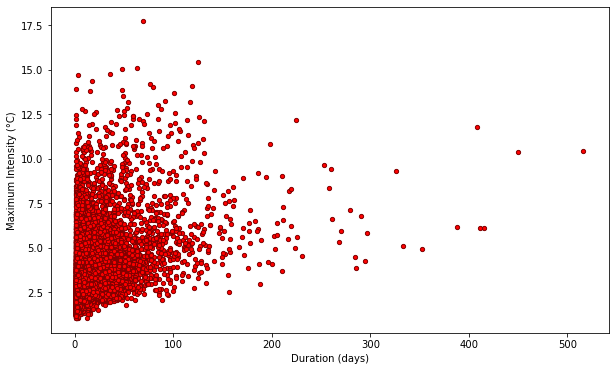

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(durations.values, intensity_total.values, alpha=1, s=18,color='red',
            edgecolors='maroon')  # s=point size, alpha=transparency

plt.xlabel('Duration (days)')
#plt.colorbar(label='Count')


plt.ylabel(type_+' Intensity (°C)')

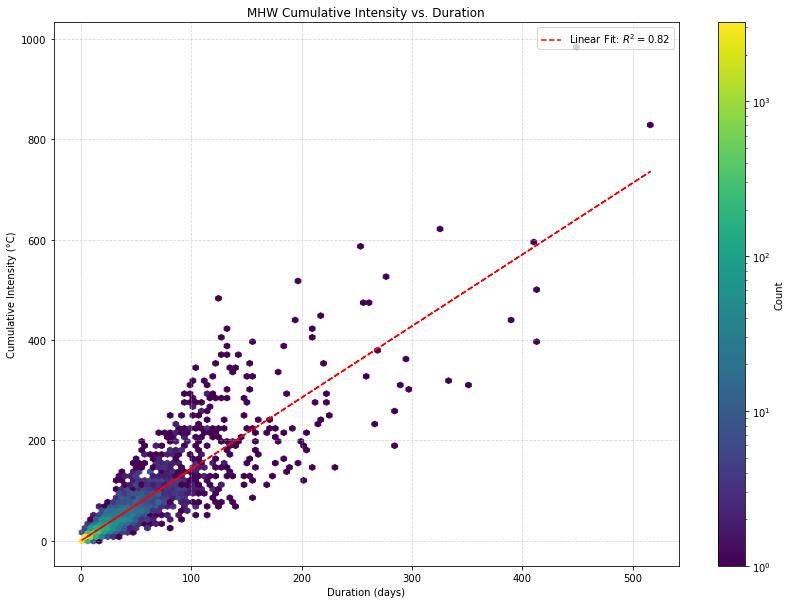

In [13]:

plt.figure(figsize=(14, 10))
#plt.scatter(durations.values, intensity_total.values, alpha=0.5, s=10)  # s=point size, alpha=transparency
plt.xlabel('Duration (days)')
plt.hexbin(durations.values, intensity_total.values, gridsize=100, cmap='viridis', bins='log')
mask = ~np.isnan(durations.values) & ~np.isnan(intensity_total.values)
x = durations.values[mask]
y = intensity_total.values[mask]

# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

plt.plot(x, intercept + slope * x, 'r--', 
         label=f'Linear Fit: $R^2 = {r_value**2:.2f}$')
plt.colorbar(label='Count')
plt.legend()
plt.ylabel(type_+' Intensity (°C)')
plt.title('MHW '+type_+' Intensity vs. Duration')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

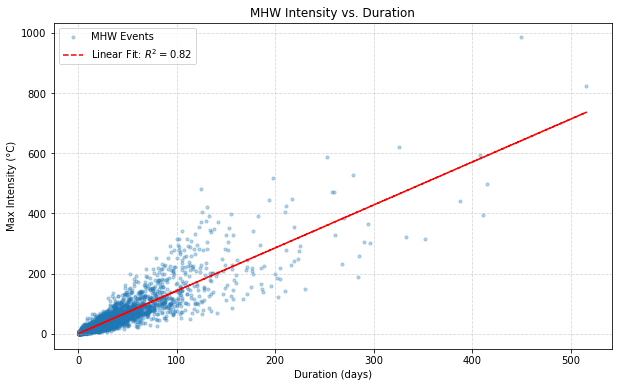

In [11]:


# Extract values and remove NaNs
mask = ~np.isnan(durations.values) & ~np.isnan(intensity_total.values)
x = durations.values[mask]
y = intensity_total.values[mask]

# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot scatter + regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.3, s=10, label='MHW Events')
plt.plot(x, intercept + slope * x, 'r--', 
         label=f'Linear Fit: $R^2 = {r_value**2:.2f}$')
plt.xlabel('Duration (days)')
plt.ylabel('Max Intensity (°C)')
plt.title('MHW Intensity vs. Duration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Different durations vs intensity

number of events left is 134
New R² = 0.41


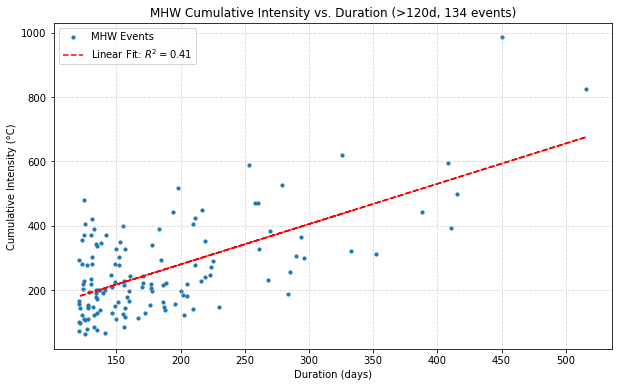

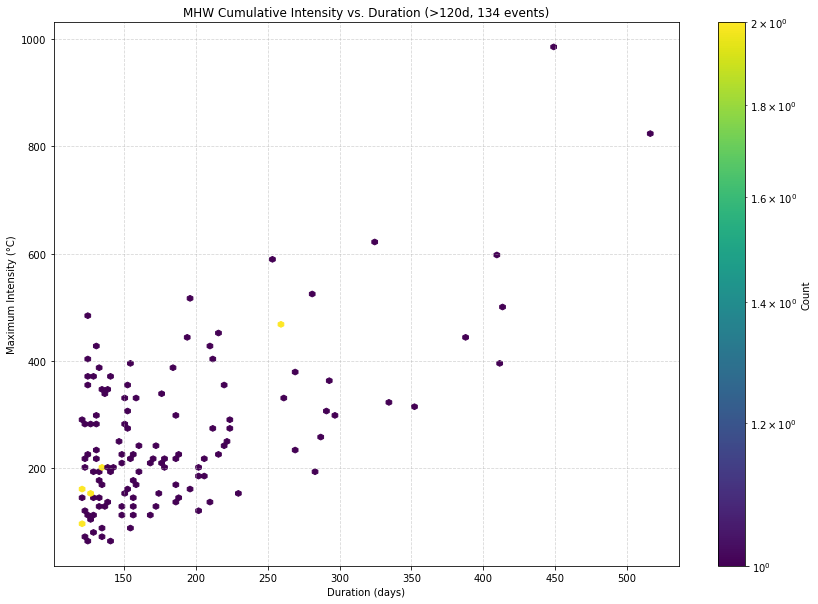

In [25]:

#mask = ((durations >30) & (durations<60)).compute() 
mask = ((durations >120)).compute() 
print('number of events left is',mask.sum().values)
title='MHW '+type_+' Intensity vs. Duration (>120d, '+str(mask.sum().values)+' events)'
# Apply the mask
durations_long = durations.where(mask, drop=True)
intensity_long = intensity_total.where(mask, drop=True)

# Remove NaNs and extract values
mask_non_nan = ~np.isnan(durations_long.values) & ~np.isnan(intensity_long.values)
x = durations_long.values[mask_non_nan]
y = intensity_long.values[mask_non_nan]

# Compute regression on the CURRENT filtered data
slope, intercept, r_value, p_value, _ = linregress(x, y)
print(f"New R² = {r_value**2:.2f}")  # Check if this updates

# Plot scatter + regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=1, s=10, label='MHW Events')
plt.plot(x, intercept + slope * x, 'r--', 
         label=f'Linear Fit: $R^2 = {r_value**2:.2f}$')
plt.xlabel('Duration (days)')
plt.ylabel(type_+' Intensity (°C)')
plt.title(title)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


plt.figure(figsize=(14, 10))
#plt.scatter(durations.values, intensity_total.values, alpha=0.5, s=10)  # s=point size, alpha=transparency
plt.xlabel('Duration (days)')
plt.hexbin(durations_long.values, intensity_long.values, gridsize=100, cmap='viridis', bins='log')
plt.colorbar(label='Count')

plt.ylabel('Maximum Intensity (°C)')
plt.title(title)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Diferent intansities vs duration

number of events left is 0
New R² = 0.05


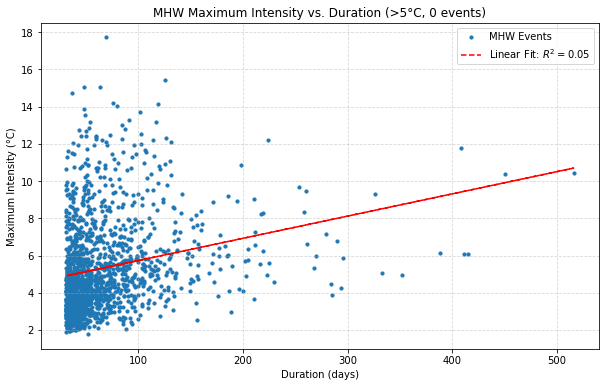

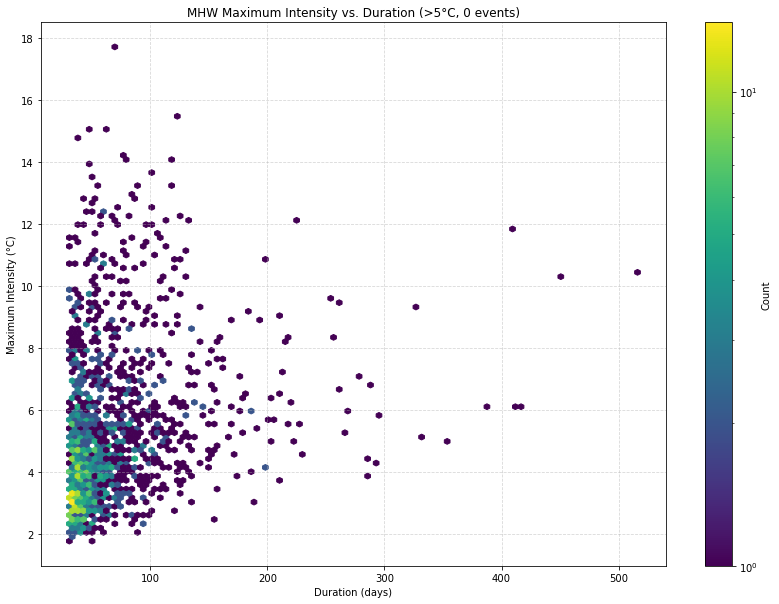

In [42]:

#mask = ((intensity_total >30) & (intensity_total<60)).compute() 
mask = ((intensity_total <1)).compute() 
mask1 = ((durations >30)).compute() 
print('number of events left is',mask.sum().values)
title='MHW '+type_+' Intensity vs. Duration (>5°C, '+str(mask.sum().values)+' events)'
# Apply the mask
durations_long = durations.where(mask, drop=True)
durations_long = durations.where(mask1, drop=True)
intensity_long = intensity_total.where(mask, drop=True)
intensity_long = intensity_total.where(mask1, drop=True)

# Remove NaNs and extract values
mask_non_nan = ~np.isnan(durations_long.values) & ~np.isnan(intensity_long.values)
x = durations_long.values[mask_non_nan]
y = intensity_long.values[mask_non_nan]

# Compute regression on the CURRENT filtered data
slope, intercept, r_value, p_value, _ = linregress(x, y)
print(f"New R² = {r_value**2:.2f}")  # Check if this updates

# Plot scatter + regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=1, s=10, label='MHW Events')
plt.plot(x, intercept + slope * x, 'r--', 
         label=f'Linear Fit: $R^2 = {r_value**2:.2f}$')
plt.xlabel('Duration (days)')
plt.ylabel(type_+' Intensity (°C)')
plt.title(title)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


plt.figure(figsize=(14, 10))
#plt.scatter(durations.values, intensity_total.values, alpha=0.5, s=10)  # s=point size, alpha=transparency
plt.xlabel('Duration (days)')
plt.hexbin(durations_long.values, intensity_long.values, gridsize=100, cmap='viridis', bins='log')
plt.colorbar(label='Count')

plt.ylabel('Maximum Intensity (°C)')
plt.title(title)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# various previous attempts at finding the max intensity

In [ ]:
# THIS works with a small dataset
# Modified core function to handle empty masks
def max_intensity(sst_np, id_field_np, id_val):
    """Compute max SSTA where ID matches, handling empty masks"""
    mask = id_field_np == id_val
    if np.any(mask):
        return np.nanmax(sst_np[mask])
    else:
        return np.nan  # Return NaN if ID not present

# Create ID coordinate array
IDs = xr.DataArray(blobs_ds.ID, dims=['ID'], name='ID')

# Apply ufunc with corrected dimension handling
intensity_time = xr.apply_ufunc(
    max_intensity,
    ssta,          # [time, lat, lon]
    blobs_ds.ID_field, # [time, lat, lon]
    IDs,           # [ID]
    input_core_dims=[
        ['lat', 'lon'],  # ssta: process 2D slices
        ['lat', 'lon'],  # ID_field: process 2D slices
        []               # ID: scalar input
    ],
    output_core_dims=[[]],  # Scalar output per (time, ID)
    exclude_dims={'lat', 'lon'},  # These are processed in the function
    vectorize=True,  # Required for automatic broadcasting over time/ID
    dask='parallelized',
    output_dtypes=[float]
)

# Compute maximum over time dimension
intensity_total = intensity_time.max(dim='time').compute()

In [10]:
def max_intensity(sst_np, id_field_np, id):
    # Takes np arrays;  (time id lat lon
    mask = id_field_np == id
    return np.nanmax(sst_np[mask])
    #return np.max(sst_np)

In [16]:
def max_intensity(sst_np, id_field_np, id):
    # Takes np arrays;  (time id lat lon
    mask = id_field_np == id
    return np.nanmax(sst_np[mask])
    #return np.max(sst_np)

intensity_time = xr.apply_ufunc(max_intensity,
                                ssta,
                                blobs,
                                IDs,
                                input_core_dims=[['lat', 'lon'], ['lat', 'lon'], []],
                                output_core_dims=[[]],
                                dask='parallelized',
                                vectorize=True
                                )

intensity_total = intensity_time.max(dim='time')

In [17]:
intensity_total=intensity_total.compute()

2025-03-26 14:16:54,731 - distributed.worker - ERROR - Compute Failed
Key:       ('vectorize_max_intensity-vectorize_max_intensity_0-nanmax_skip-90ff76c85bd05e35a3882c1f2a05a4a9', 39, 82)
State:     executing
Function:  execute_task
args:      ((subgraph_callable-ea4a55b18335e657bd4395550fb8628b, (subgraph_callable-770e875d416468ba01f285073678d905, (<function concatenate_axes at 0x7fffc8d94b80>, [[array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [-7.62962300e-05, -7.52199194e-05, -7.39100869e-05, ...,
          -7.97518296e-05, -7.87947283e-05, -7.76044326e-05],
         [-9.84672006e-05, -9.93011781e-05, -1.00135476e-04, ...,
       

ValueError: zero-size array to reduction operation fmax which has no identity

     nan,             n
kwargs:    {}
Exception: "ValueError('zero-size array to reduction operation fmax which has no identity')"
Traceback: '  File "/home/b/b382616/.local/lib/python3.9/site-packages/dask/optimization.py", line 1001, in __call__\n    return core.get(self.dsk, self.outkey, dict(zip(self.inkeys, args)))\n  File "/home/b/b382616/.local/lib/python3.9/site-packages/dask/core.py", line 157, in get\n    result = _execute_task(task, cache)\n  File "/home/b/b382616/.local/lib/python3.9/site-packages/dask/core.py", line 127, in _execute_task\n    return func(*(_execute_task(a, cache) for a in args))\n  File "/home/b/b382616/.local/lib/python3.9/site-packages/numpy/lib/function_base.py", line 2372, in __call__\n    return self._call_as_normal(*args, **kwargs)\n  File "/home/b/b382616/.local/lib/python3.9/site-packages/numpy/lib/function_base.py", line 2365, in _call_as_normal\n    return self._vectorize_call(func=func, args=vargs)\n  File "/home/b/b382616/.local/lib/python3.9/s

In [ ]:
intensity_total

In [43]:
intensity_total=intensity_total.persist()

2025-03-25 15:36:13,491 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-ID_field-4fe910b331935df05f51ca4e92ad8f46' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7fff0e89f280>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7fff7a0d75c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x7fff0e89f280>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(

In [13]:

# Initialize storage for maxima (Dask array)
max_intensities = dask.array.full(len(blobs_ds.ID), -np.inf, chunks=1000)

def process_time_chunk(time_slice):
    """Process a chunk of time steps and return partial maxima"""
    # Load chunk data
    chunk_presence = presence.isel(time=time_slice).compute()
    chunk_blobs = blobs.isel(time=time_slice).compute()
    chunk_ssta = ssta.isel(time=time_slice).compute()
    
    chunk_max = np.full(len(blobs_ds.ID), -np.inf)
    
    for t in range(len(time_slice)):
        active_events = np.where(chunk_presence[t])[0]
        for event_id in active_events:
            mask = chunk_blobs[t] == blobs_ds.ID.values[event_id]
            if mask.any():
                current_max = chunk_ssta[t].where(mask).max().item()
                chunk_max[event_id] = max(chunk_max[event_id], current_max)
    
    return chunk_max

# Create parallel computation graph
time_chunks = [slice(i, i+1000) for i in range(0, len(blobs_ds.time), 1000)]
futures = [dask.delayed(process_time_chunk)(chunk) for chunk in time_chunks]

# Combine results using tree reduction
from dask import delayed
@delayed
def update_max(current_max, new_chunk):
    return np.maximum(current_max, new_chunk)

result = delayed(np.full)(len(blobs_ds.ID), -np.inf)
for future in futures:
    result = update_max(result, future)



In [64]:
iduno=blobs.where((blobs==1).compute(),drop=True)

In [86]:

active_times = blobs_ds['presence'].sel(ID=1).compute()

# Create spatial-temporal mask for ID=1
mask = (blobs.compute() == 1)  # Convert to numpy array

In [87]:
iduno = blobs.where(mask, drop=True)
sstauno = ssta.where(mask, drop=True)

In [84]:
sstauno

<xarray.DataArray 'dat_detrend' (time: 13879, lat: 721, lon: 1440)> Size: 115GB
dask.array<where, shape=(13879, 721, 1440), dtype=float64, chunksize=(1000, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 111kB 2002-01-01T23:59:00 ... 2039-12-31T2...

In [67]:
sstauno=sstauno.compute()

In [82]:
# Create 3D mask where blob ID = 1
mask = blobs == 1  # Dimensions: (time, lat, lon)

# Apply mask to both datasets
idunoo = blobs.where(mask, drop=True)  # Masked ID field
sstaunoo = ssta.where(mask, drop=True)  # Masked SSTA



2025-03-17 17:25:36,122 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-ID_field-cda71be42555ffff22e96a19069028cb' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7fff0e8a1160>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffe84683d00>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x7fff0e8a1160>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(

KeyError: 'Indexing with a boolean dask array is not allowed. This will result in a dask array of unknown shape. Such arrays are unsupported by Xarray.Please compute the indexer first using .compute()'

In [49]:
sstauno.isel(time=0).values.max()

Task exception was never retrieved
future: <Task finished name='Task-820478' coro=<Client._gather.<locals>.wait() done, defined at /home/b/b382616/.local/lib/python3.9/site-packages/distributed/client.py:2396> exception=AllExit()>
Traceback (most recent call last):
  File "/home/b/b382616/.local/lib/python3.9/site-packages/distributed/client.py", line 2405, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-820479' coro=<Client._gather.<locals>.wait() done, defined at /home/b/b382616/.local/lib/python3.9/site-packages/distributed/client.py:2396> exception=AllExit()>
Traceback (most recent call last):
  File "/home/b/b382616/.local/lib/python3.9/site-packages/distributed/client.py", line 2405, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-820480' coro=<Client._gather.<locals>.wait() done, defined at /home/b/b382616/.local/lib/python3.9/si

9.0

In [42]:


event_mask = current_blobs == blobs_ds.ID.values[event_id]
            
            # Calculate max intensity at this timestep
current_max = current_ssta.where(event_mask).max().values

2025-03-17 17:02:35,325 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-dat_detrend-af8c7b0c0e87b46b516838d3d8b9f5b1' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: memory
old run_spec: (<function execute_task at 0x7fff0e8a1160>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7fff4d44f280>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x7fff0e8a1160>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray

ERROR! Session/line number was not unique in database. History logging moved to new session 2615


/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **

In [41]:
sstauno.where(iduno).max(dim='time').plot()

/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/b/b382616/.local/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **

In [14]:
# Compute final result
final_max = result.compute()

# Convert to Xarray and save
max_da = xr.DataArray(
    final_max,
    dims=['ID'],
    coords={'ID': blobs_ds.ID},
    attrs={'units': '°C', 'description': 'Maximum MHW intensity'}
)


2025-03-17 16:48:32,281 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-presence-08c16e65b70036c921b40d0f70f8af1a' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: processing
old run_spec: (<function execute_task at 0x7fff0e8a1160>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=BoolTypeArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7fff77ba6d40>, key=BasicIndexer((slice(None, None, None), slice(None, None, None))))), key=BasicIndexer((slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<functi

KilledWorker: Attempted to run task 'process_time_chunk-59635c7e-8eb7-4a1e-9e97-a29e78e7ee63' on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:33149. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

2025-03-17 16:49:23,393 - distributed.worker.memory - WARNING - Worker is at 53% memory usage. Resuming worker. Process memory: 7.97 GiB -- Worker memory limit: 14.90 GiB
2025-03-17 16:49:25,546 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 11.97 GiB -- Worker memory limit: 14.90 GiB
2025-03-17 16:49:26,746 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.88 GiB -- Worker memory limit: 14.90 GiB
2025-03-17 16:49:31,505 - distributed.worker.memory - WARNING - Worker is at 53% memory usage. Resuming worker. Process memory: 7.97 GiB -- Worker memory limit: 14.90 GiB
2025-03-17 16:49:33,746 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 11.

In [10]:
from dask.distributed import performance_report
# 4. Time-step oriented processing function
def process_timestep(ssta_t, blobs_t, presence_t, id_values):
    """Compute max intensities for all active IDs at one timestep"""
    results = np.full(len(id_values), np.nan)
    active_ids = np.where(presence_t.compute())[0]  # Compute here to avoid Dask graph bloat
    
    for idx in active_ids:
        mask = blobs_t == id_values[idx]
        if mask.any():
            results[idx] = ssta_t.where(mask).max().item()
    return results

# 5. Parallel execution with minimal dependencies
with performance_report(filename="dask-report.html"):
    max_intensities = xr.apply_ufunc(
        process_timestep,
        ssta,
        blobs,
        presence,
        blobs_ds.ID,
        input_core_dims=[[], [], ['ID'], ['ID']],
        output_core_dims=[['ID']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float],
        dask_gufunc_kwargs={
            'allow_rechunk': True,
            'output_sizes': {'ID': len(blobs_ds.ID)}
        }
    ).max(dim='time')



In [16]:
from dask.distributed import performance_report
# 4. Time-step oriented processing function
def process_timestep(ssta_t, blobs_t, presence_t, id_values):
    """Compute max intensities for all active IDs at one timestep"""
    results = np.full(len(id_values), -np.inf)  # Use -inf instead of NaN to avoid issues
    active_ids = np.where(presence_t.compute())[0]  
    
    for idx in active_ids:
        mask = blobs_t == id_values[idx]
        if mask.any():
            results[idx] = ssta_t.where(mask).max().item()
    
    return results


# 5. Parallel execution with minimal dependencies
with performance_report(filename="dask-report.html"):
    max_intensities = xr.apply_ufunc(
        process_timestep,
        ssta,
        blobs,
        presence,
        blobs_ds.ID,
        input_core_dims=[[], [], ['ID'], ['ID']],
        output_core_dims=[['ID']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float],
        dask_gufunc_kwargs={
            'allow_rechunk': True,
            'output_sizes': {'ID': len(blobs_ds.ID)}
        }
    ).max(dim='time')



ERROR! Session/line number was not unique in database. History logging moved to new session 2611


In [ ]:
max_intensities = max_intensities.persist()

In [62]:
for time in range(13879):
    for i in range(len(blobs_ds.ID)):
        blobs1=blobs.isel(time=time)
        ssta.sel(time=blobs1.time).where(blobs1==ssta.sel(time=blobs1.time).where(blobs1==blobs_ds.ID.values[i]))





<xarray.DataArray 'ID_field' (lat: 721, lon: 1440)> Size: 4MB
dask.array<getitem, shape=(721, 1440), dtype=int32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    time     datetime64[ns] 8B 2002-01-02T23:59:00

In [ ]:
for time in range(13):
    blobs_here=np.where(blobs_ds.presence.isel(time=time))[0]
    for i in blobs_here:
        blobs1=blobs.isel(time=time)
        ra=ssta.isel(time=time).where(blobs1==i).max().compute().values
        blobsreturn[i]=ra

return blobsreturn


In [21]:
blobsreturn=np.zeros(12)
for time in range(13):
    blobs_here=np.where(blobs_ds.presence.isel(time=time))[0]
    for i in blobs_here:
        blobs1=blobs.isel(time=time)
        ra=ssta.isel(time=time).where(blobs1==i).max().compute().values
        blobsreturn[i]=ra


2025-03-14 12:52:24,558 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-presence-a4042194027f5e1429abd144625a79bc' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7fff278ac1f0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=BoolTypeArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffd2c16c440>, key=BasicIndexer((slice(None, None, None), slice(None, None, None))))), key=BasicIndexer((slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function

IndexError: index 12 is out of bounds for axis 0 with size 12

In [94]:
#THIS IS TO CHECK THAT THE FUNCTION max_int_temp  IS CORRECT
#BY CHECKING THAT THE MAX INTENSITY OF ID 1 IS CORRECT
#IT IS INDEED CORRECT

blubs=blobs.isel(time=slice(0,52)).compute()
stu=ssta.isel(time=slice(0,52)).compute()

stu_masked = stu.where(blubs == 1)
max_intensity = np.nanmax(stu_masked.max(dim='time',skipna=True).values)



In [95]:
def max_int_temp():
    # Initialize with -infinity instead of zeros to properly track maxima
    blobsreturn = np.full(48, -np.inf)
    
    for time in range(49):
        # Get active events at current time
        active_events = np.where(blobs_ds.presence.isel(time=time))[0]
        
        # Get data for current timestep
        current_blobs = blobs.isel(time=time)
        current_ssta = ssta.isel(time=time)
        
        for event_id in active_events:
            # Create mask for this event's spatial extent
            event_mask = current_blobs == blobs_ds.ID.values[event_id]
            
            # Calculate max intensity at this timestep
            current_max = current_ssta.where(event_mask).max().values
            
            # Update global maximum if current is larger
            if current_max > blobsreturn[event_id]:
                blobsreturn[event_id] = current_max
            return blobsreturn

5.5068072219216955

In [ ]:
presence=blobs_ds['presence'].compute()
# Initialize with -infinity for proper max tracking
max_intensities = np.full(len(blobs_ds.ID), -np.inf)
event_ids = blobs_ds.ID.values  # Store actual IDs
def max_int_ufunc(ssta,blobs):
    for time in range(len(blobs_ds.time)):
        # Get active events at current time
        active_events = np.where(presence.isel(time=time))[0]
        
        # Get data for current timestep
        current_blobs = blobs.isel(time=time)
        current_ssta = ssta.isel(time=time)
        
        for idx in active_events:
            # Get actual event ID
            event_id = event_ids[idx]
            
            # Create mask and calculate max
            event_mask = current_blobs == event_id
            current_max = current_ssta.where(event_mask).max().values
            
            # Update global maximum
            if current_max > max_intensities[idx]:
                max_intensities[idx] = current_max



results=xr.apply_ufunc(
    max_int_ufunc,  # first the function
    stu,  # now arguments in the order expected by 'interp1_np'
    blubs,
    input_core_dims=[["lat","lon"],["lat","lon"]],
    exclude_dims=set(("lat","lon",)),  # dimensions allowed to change size. Must be set!
)



In [115]:
np.where(presence.time)[0]

array([    0,     1,     2, ..., 13876, 13877, 13878])

In [8]:
%%time
presence = blobs_ds.presence.chunk({'ID': 100})  # Chunk IDs for parallel processing

# Define core function for parallel processing per ID
def process_id(presence_1d, ssta_3d, blobs_3d, id_val):
    """Compute max intensity for a single ID across all times"""
    active_times = np.where(presence_1d)[0]
    max_intensity = -np.inf
    
    for t in active_times:
        # Create mask for this ID at current time
        mask = blobs_3d[t] == id_val
        if mask.any():
            current_max = ssta_3d[t].where(mask).max().item()
            max_intensity = max(max_intensity, current_max)
    
    return max_intensity if max_intensity != -np.inf else np.nan

# Wrap for xarray compatibility
def wrapped_process_id(presence_1d, ssta_3d, blobs_3d, id_val):
    return process_id(presence_1d, ssta_3d, blobs_3d, id_val)

# Create ID coordinate array
ids = xr.DataArray(blobs_ds.ID, dims=['ID'], name='ID')

# Parallel computation using apply_ufunc
max_intensities = xr.apply_ufunc(
    wrapped_process_id,
    presence,        # [time, ID]
    ssta,            # [time, lat, lon]
    blobs,           # [time, lat, lon]
    ids,             # [ID]
    input_core_dims=[['time'], ['time', 'lat', 'lon'], ['time', 'lat', 'lon'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],
    dask_gufunc_kwargs={'allow_rechunk': True}
)

# Add metadata and save
max_intensities = max_intensities.assign_coords(ID=blobs_ds.ID)
max_intensities.attrs = {
    'long_name': 'Maximum SST anomaly intensity',
    'units': '°C'
}


CPU times: user 645 ms, sys: 15.8 ms, total: 661 ms
Wall time: 660 ms


In [ ]:
ssta

In [ ]:
ssta=ssta.compute()

In [9]:
%%time
# Test with first 10 IDs
test_result = max_intensities.compute()


2025-03-17 16:05:31,473 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <distributed.dashboard.core.DaskBokehTornado object at 0x7ffe643e34f0>>
Traceback (most recent call last):
  File "/sw/spack-levante/jupyterhub/jupyterhub/lib/python3.9/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
  File "/home/b/b382616/.local/lib/python3.9/site-packages/bokeh/server/tornado.py", line 787, in _keep_alive
    c.send_ping()
  File "/home/b/b382616/.local/lib/python3.9/site-packages/bokeh/server/connection.py", line 91, in send_ping
    self._socket.ping(str(self._ping_count).encode("utf-8"))
  File "/sw/spack-levante/jupyterhub/jupyterhub/lib/python3.9/site-packages/tornado/websocket.py", line 440, in ping
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
2025-03-17 16:05:38,481 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <distributed.dashboard.co

MemoryError: Task ('vectorize_wrapped_process_id-vectorize_wrapped_process_id_0-transpose-5100bf49e322c5dd36ed68f38d808005', 85) has 161.04 GiB worth of input dependencies, but worker tcp://127.0.0.1:33095 has memory_limit set to 7.36 GiB.

2025-03-17 16:10:15,518 - distributed.scheduler - ERROR - Task ('vectorize_wrapped_process_id-vectorize_wrapped_process_id_0-transpose-5100bf49e322c5dd36ed68f38d808005', 99) has 161.04 GiB worth of input dependencies, but worker tcp://127.0.0.1:33095 has memory_limit set to 7.36 GiB.
2025-03-17 16:10:17,280 - distributed.scheduler - ERROR - Task ('vectorize_wrapped_process_id-vectorize_wrapped_process_id_0-transpose-5100bf49e322c5dd36ed68f38d808005', 98) has 161.04 GiB worth of input dependencies, but worker tcp://127.0.0.1:33095 has memory_limit set to 7.36 GiB.
2025-03-17 16:10:19,060 - distributed.scheduler - ERROR - Task ('vectorize_wrapped_process_id-vectorize_wrapped_process_id_0-transpose-5100bf49e322c5dd36ed68f38d808005', 97) has 161.04 GiB worth of input dependencies, but worker tcp://127.0.0.1:33095 has memory_limit set to 7.36 GiB.
2025-03-17 16:10:20,843 - distributed.scheduler - ERROR - Task ('vectorize_wrapped_process_id-vectorize_wrapped_process_id_0-transpose-5100bf49e3

In [ ]:
# Create xarray Dataset with IDs and maxima
results_ds = xr.Dataset({
    'max_intensity': (['ID'], max_intensities),
    'event_id': (['ID'], event_ids)
})

# Add metadata
results_ds['max_intensity'].attrs = {
    'units': '°C',
    'long_name': 'Maximum SST anomaly intensity'
}
results_ds['event_id'].attrs = {
    'description': 'MHW event identifier'
}


In [98]:
max_intensities

array([5.50680722, 4.48938174, 4.16445299, 2.28951213, 3.04556314,
       2.55590223, 2.70208996, 3.98611537, 5.07855985, 2.26182189,
       5.55760214, 3.67890585, 2.38911251, 2.44337586, 2.51194015,
       3.74036956, 4.10555734, 4.31951357, 4.04584372, 2.18627367,
       5.83864643, 4.36085646, 3.66528077, 2.02397308, 2.52049556,
       2.7408041 , 2.52402634, 2.22220033, 2.39513792, 2.75610845,
       3.33710441, 4.9204963 , 2.92802383, 1.78355435, 2.76482478,
       2.81588626, 4.08245007, 1.9243065 , 2.57368496, 2.2701144 ,
       3.29879623, 3.13545904, 2.18742964, 3.46694548, 1.89814223,
       1.63296532, 2.53832527, 2.49689463])

In [48]:

# Initialize with -infinity instead of zeros to properly track maxima
blobsreturn = np.full(48, -np.inf)

for time in range(49):
    # Get active events at current time
    active_events = np.where(blobs_ds.presence.isel(time=time))[0]
    
    # Get data for current timestep
    current_blobs = blobs.isel(time=time)
    current_ssta = ssta.isel(time=time)
    
    for event_id in active_events:
        # Create mask for this event's spatial extent
        event_mask = current_blobs == blobs_ds.ID.values[event_id]
        
        # Calculate max intensity at this timestep
        current_max = current_ssta.where(event_mask).max().values
        
        # Update global maximum if current is larger
        if current_max > blobsreturn[event_id]:
            blobsreturn[event_id] = current_max

2025-03-14 13:03:55,642 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-presence-a4042194027f5e1429abd144625a79bc' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7fff278ac1f0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=BoolTypeArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffce638d040>, key=BasicIndexer((slice(None, None, None), slice(None, None, None))))), key=BasicIndexer((slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function

In [15]:
def max_int(ssta1,blobs1,presence1):
    blobs_here=np.where(presence1.isel(time=time))[0]
    for i in blobs_here:
        blobs1=blobs.isel(time=time)
        ra=ssta.isel(time=time).where(blobs1==i).max().compute().values
        blobsreturn[i]=ra

return blobsreturn


array([ 0,  1,  2,  5,  7,  8,  9, 10, 11, 14, 15, 16, 18, 19])

In [14]:
for time in range(13):
    blobs_here=np.where(blobs_ds.presence.isel(time=time))[0]
    for i in blobs_here:
        blobs1=blobs.isel(time=time)
        ra=ssta.isel(time=time).where(blobs1==i).max().compute().values
        blobsreturn[i]=ra

return blobsreturn


2025-03-11 16:34:12,869 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-presence-a7faec21dcf3421bae2e33fd430bbe2e' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7fff0e89c8b0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=BoolTypeArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffec01c88c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None))))), key=BasicIndexer((slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function

9.07980304144785
4.53907417090227
3.8502600397887714
3.2339283376320394
1.9779124756904478


2025-03-11 16:34:14,485 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-ID_field-40de174b48c4d8edd887daa81257b5f4' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7fff0e89c8b0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffe81b38cc0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x7fff0e89c8b0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(

2.3326134305159125
1.3066070670093084
2.702089959544548
9.444713215135645
4.939865032198283
3.847811938753622
3.8356326613230145
2.2359154298935797
2.8315062457344866
1.511233337280953
2.021565262672114
3.229846621254439
9.828707193718975
5.192146526809669
3.896558741697573
3.69001232066612
2.196203260174049
3.0455631373537986
1.8582090075147255
2.1543512289809716
2.4990603339889574
3.6347181424039348
9.733820557539065
5.5068072219216955
3.8441845232745724
3.462874421689788
1.9181058268776754
2.6185437549137345
1.8050340955062143
1.8649629597138524
2.397991492234941
4.128735217520572
1.829160181995936
9.183234230259272
5.005495886479476
3.8160683097813095
3.4104614536396514
2.2895121292061313
1.878328523929812
1.8083894831634595
1.789519221924751
2.3830718560906883
4.741692320568622
2.0067847327071364
2.346440638407379
2.3656432149041975
8.998269966351586
4.670975092064979
4.489381742484392
nan
1.8635796512540672
1.6385043328778541
2.336650051919446
4.769912947279793
2.0046696774137596

2025-03-11 16:34:37,448 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-dat_detrend-fbff940289db87aef8a8afaaa8e89afb' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7fff0e89c8b0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffe7f6804c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x7fff0e89c8b0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArr

3.3226727928206716
2.1638473895140327
2.9452681582400717
nan
2.0976346047668177
8.043573962220067
4.91437159512115
3.772795084657146
nan
nan
2.4167153418957783
3.153853945758261
2.159619081031018
3.01392480838005
nan
1.9040579752946902
2.621710565024621
3.048551393947647
7.847555156736994
5.12742201546391
4.316167155279031
nan
nan
2.5620616066782
3.677634957119764
2.2618218866338045
3.196975673132119
nan
1.6334471786214793
2.8675686521939814
3.0722325100091705
7.326058904106553
4.825829214930863
3.696303382333824
nan
nan
2.6384062579036947
4.313453683399982
2.2343375538019115
3.080725724594155
nan
2.0718354904804395
3.0012162264507594
nan
4.045843720673542


In [11]:

presence = blobs_ds.presence


def max_intensity_wrapper(ssta_time, blobs_time, presence_time):
    """Process a single time step"""
    results = np.full(presence_time.shape[0], np.nan)  # One value per ID
    
    # Find active events at this time
    active_ids = np.where(presence_time)[0]
    
    for idx in active_ids:
        event_id = blobs_ds.ID.values[idx]
        # Find spatial locations for this event
        event_mask = (blobs_time == event_id)
        if np.any(event_mask):
            results[idx] = np.nanmax(ssta_time[event_mask])
            
    return results



In [25]:
ssta.shape[0]

13879

In [28]:
import xarray as xr
import numpy as np

# Determine the maximum possible number of blobs
max_blobs = int(blobs_ds['presence'].sum(dim="time").max().compute().values)

def max_int(ssta1, blobs1, presence1):
    """Computes max ssta intensity for each event (blob) at a single time step."""
    
    # Identify blobs present at this time step
    blobs_here = np.where(presence1)[0]
    
    # Pre-fill with NaNs to maintain fixed size
    max_intensities = np.full(max_blobs, np.nan)

    # Compute max intensity for each blob
    for idx, blob_id in enumerate(blobs_here):
        if idx < max_blobs:  # Ensure we don't exceed fixed size
            max_intensities[idx] = ssta1.where(blobs1 == blob_id).max().compute().values

    return max_intensities

# Apply the function using xarray's apply_ufunc
result = xr.apply_ufunc(
    max_int, 
    ssta, blobs, blobs_ds['presence'],
    input_core_dims=[["time"], ["time"], ["time"]],
    output_core_dims=[["ID"]],  # Only keep blob ID as dimension
    output_sizes={"ID": 11},  # Define final expected shape
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
    dask_gufunc_kwargs={"allow_rechunk": True}
)

print(result)


<xarray.DataArray (time: 13879, lat: 721, lon: 1440, ID: 11692, blobs: 517)> Size: 697PB
dask.array<transpose, shape=(13879, 721, 1440, 11692, 517), dtype=float64, chunksize=(25, 721, 1440, 1462, 517), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 111kB 2002-01-01T23:59:00 ... 2039-12-31T2...
  * ID       (ID) int32 47kB 1 2 3 4 5 6 ... 11687 11688 11689 11690 11691 11692
Dimensions without coordinates: blobs


In [29]:
result

<xarray.DataArray (time: 13879, lat: 721, lon: 1440, ID: 11692, blobs: 517)> Size: 697PB
dask.array<transpose, shape=(13879, 721, 1440, 11692, 517), dtype=float64, chunksize=(25, 721, 1440, 1462, 517), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 111kB 2002-01-01T23:59:00 ... 2039-12-31T2...
  * ID       (ID) int32 47kB 1 2 3 4 5 6 ... 11687 11688 11689 11690 11691 11692
Dimensions without coordinates: blobs

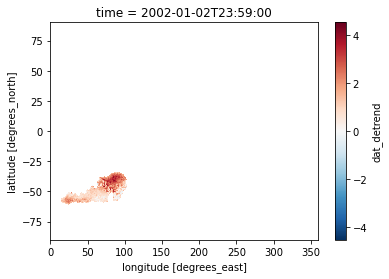

In [70]:

blobs1=blobs.isel(time=1)
ssta.sel(time=blobs1.time).where(blobs1==1).plot()